In [368]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [688]:
#Read in surface stats
db = pickle.load(open('workspace/SFstats.pck','rb'))
#Read in LES output
file = 'workspace/LESoutput.pck'
les_db = pickle.load(open(file,'rb'))

In [726]:
#Assemble metrics
metrics = {}
dates =[]
eps = 10**-10
for var in ['TKE','LWP']:
 metrics[var] = []
 #Perform analysis at each date
 for date in les_db:
     if var == 'TKE':dates.append(datetime.datetime.strptime(date,'%Y-%m-%d'))
     hmg = les_db[date]['HMG'][var]
     htg = les_db[date]['HTG'][var]    
     if (np.sum(hmg != -9999) >= 90) & (np.sum(htg != -9999) >= 90):
         m2 = (htg != -9999) & (hmg != -9999)
         metrics[var].append(np.mean(htg[m2]-hmg[m2]))
         #if var == 'TKE':
         # plt.title(np.mean(htg[m2]-hmg[m2]))
          #plt.plot(hmg[m2])
          #plt.plot(htg[m2])
          #plt.show()
         #metrics[var].append(np.mean(htg[m2]-hmg[m2]))
         #metrics[var].append(np.mean(htg[m2])-np.mean(hmg[m2]))
         #metrics[var].append(np.mean(np.log2(htg[m2]+eps)-np.log2(hmg[m2]+eps)))
     else:
         metrics[var].append(-9999)
 metrics[var] = np.array(metrics[var])
 m = metric != -9999
dates = np.array(dates)

0.5801660692716399


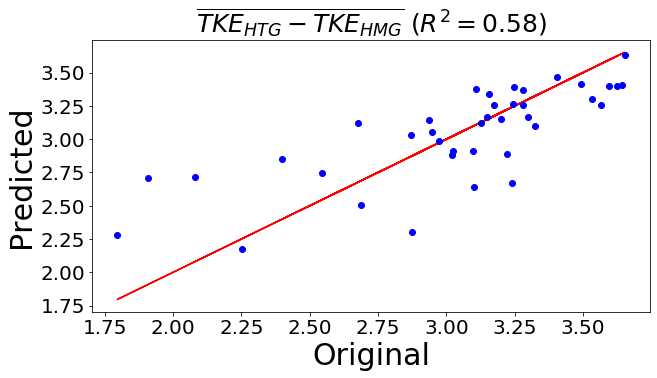

In [795]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.metrics
var = 'TKE'
metric = metrics[var]
m2 = m & (metrics['TKE'] < 5000)
#X = np.array([db['SH_L0_0.75'][m2],db['SH_L90'][m2],db['SH_var'][m2],db['SH_skew'][m2],db['SH_kurt'][m2]]).T
#X = np.array([db['SH_L0_0.50'][m2],db['SH_L90_0.50'][m2],db['SH_var'][m2],db['SH_skew'][m2],db['SH_kurt'][m2]]).T
#X = np.array([db['sh_L0_0.75'][m2],db['sh_L90_0.75'][m2],
#              db['lw_L0_0.75'][m2],db['lw_L90_0.75'][m2],
#              db['lh_L0_0.75'][m2],db['lh_L90_0.75'][m2],
#              db['sh_var'][m2],db['lh_var'][m2],db['lw_var'][m2],
#              db['sh_skew'][m2],db['lh_skew'][m2],db['lw_skew'][m2],
#              db['sh_kurt'][m2],db['lh_kurt'][m2],db['lw_kurt'][m2],#

##              db['ws'][m2],db['theta'][m2]]).T
#print(db['sh_L0_0.75'].shape)
#X = np.array([db['sh_L0_0.75'][m2]**2,]).T#db['ws'][m2],
X = np.array([np.log10(db['sh_L0_0.75'][m2]),np.log10(db['ws'][m2])]).T
#              db['sh_var'][m2],db['sh_mean'][m2]]).T
#X = np.array([db['sh_L0_0.75'][m2]**2,db['ws'][m2],
#              db['sh_var'][m2]]).T
#X = np.array([db['sh_L0_0.75'][m2],db['sh_var'][m2]]).T
#X = np.array([db['sh_L0_0.75'][m2],db['sh_var'][m2],db['sh_L90_0.75'][m2]]).T
#X = np.array([db['sh_L0_0.75'][m2]/db['ws'][m2],]).T
#X = np.array([db['sh_L0_0.75'][m2],]).T
#X = np.array([db['sh_L0_0.75'][m2],db['ws'][m2],]).T
#X = np.array([db['sh_mean'][m2],]).T
#X = np.array([db['SH_L0_0.75'][m2],db['SH_L0_0.50'][m2],db['SH_L0_0.25'][m2],db['SH_L90_0.75'][m2],db['SH_L90_0.50'][m2],db['SH_L90_0.25'][m2]]).T
y = metric[m2]
y = np.log10(y)
#regr = RandomForestRegressor(max_depth=2,random_state=0,n_estimators=250,oob_score=True).fit(X,y)
#regr = GradientBoostingRegressor(random_state=0).fit(X,y)
regr = LinearRegression().fit(X, y)
ypred = regr.predict(X)
print(sklearn.metrics.explained_variance_score(y,ypred))
plt.figure(figsize=(10,5))
plt.plot(y,y,'r')
plt.plot(y,ypred,'bo')
plt.xlabel('Original',fontsize=30)
plt.ylabel('Predicted',fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
if var == 'TKE':
 plt.title(r'$\overline{TKE_{HTG} - TKE_{HMG}}$ ($R^2 = %.2f$)' % sklearn.metrics.explained_variance_score(y,ypred),fontsize=25)
else:
 plt.title(r'$\overline{LWP_{HTG} - LWP_{HMG}}$ ($R^2 = %.2f$)' % sklearn.metrics.explained_variance_score(y,ypred),fontsize=25)
plt.show()

In [796]:
import sklearn.model_selection
clf = LinearRegression()
#clf = RandomForestRegressor(max_depth=2,n_estimators=250)
#clf = GradientBoostingRegressor(max_depth=2,n_estimators=250)
scores = sklearn.model_selection.cross_val_score(clf,X,y,cv=2,scoring='explained_variance')
print(np.mean(scores))
scores = sklearn.model_selection.cross_val_score(clf,X,y,cv=2,scoring='r2')
#scores = sklearn.model_selection.cross_val_score(clf,X,y,cv=2,scoring='neg_mean_squared_error')
print(np.mean(scores))

0.48780130510534514
0.4769861182419489


In [797]:
import scipy.stats

(0.7467756002070999, 4.7809119407387705e-08)


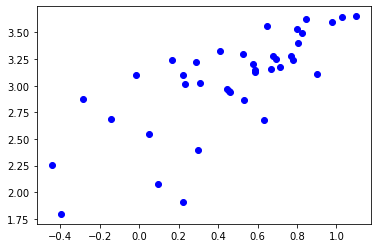

In [798]:
var = 'sh_L0_0.75'
plt.plot(np.log10(db[var][m2]),np.log10(metrics['TKE'][m2]),'bo')
print(scipy.stats.pearsonr(np.log10(db[var][m2]),np.log10(metrics['TKE'][m2])))
#print(scipy.stats.pearsonr(db[var][m2]/db['ws'][m2],metrics['TKE'][m2]))

In [617]:
dates[metric > 7000]

array([datetime.datetime(2017, 6, 27, 0, 0),
       datetime.datetime(2016, 5, 30, 0, 0),
       datetime.datetime(2016, 8, 19, 0, 0)], dtype=object)

In [620]:
def Process_sounding_data(dates):

 db = {}
 db['ws'] = []
 db['theta'] = []
 for date in dates:
    print(date)
    file = '/stor/soteria/hydro/shared/lasso_for_nate/lasso_download/sgp%d%02d%02d/config/input_sounding' % (date.year,date.month,date.day)
    data = np.loadtxt(file,skiprows=1)
    z = data[:,0]
    dz = z[1:]-z[:-1]
    iz = (z[1:] >= 0) & (z[1:] <= 20000)#20000)
    zav = (z[1:] + z[1:])/2
    f = dz[iz]/np.sum(dz[iz])
    u = ((data[1:,-2] + data[0:-1,-2])/2)[iz]
    v = ((data[1:,-1] + data[0:-1,-1])/2)[iz]
    ug = np.sum(f*u)
    vg = np.abs(np.sum(f*v))
    ws = (u**2 + v**2)**0.5
    theta = np.arctan2(np.abs(v),u)
    f = ws/np.sum(ws)
    plt.plot(u,zav[iz])
    plt.plot(v,zav[iz])
    plt.legend(['u','v'])
    plt.show()
    #plt.subplot(121)
    #plt.title('WS')
    #lt.plot(ws,av[iz])
    #plt.subplot(122)
    #plt.title('Theta (degrees)')
    #plt.plot(np.degrees(theta),zav[iz])
    #plt.show()
    #Calculate magnitude
    #db['ws'].append((ug**2 + vg**2)**0.5)
    #db['theta'].append(np.arctan2(vg,ug)) #only 0-180 degrees (on purpose)
    print(date,(ug**2+vg**2)**0.5,np.degrees(np.arctan2(vg,ug)))
    ws_ta = np.sum(f*ws)
    theta_ta = np.sum(f*theta)
    print(date,ws_ta,np.degrees(theta_ta))
 for var in db:
    db[var] = np.array(db[var])
 #Save the data
 file = 'workspace/LASSOsoundings.pck'
 pickle.dump(db,open(file,'wb'))

2017-06-27 00:00:00


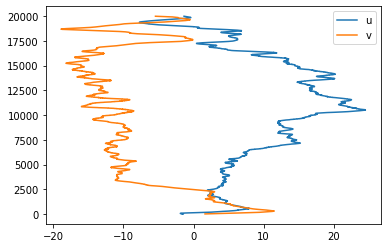

2017-06-27 00:00:00 13.405373436546455 43.52683465814736
2017-06-27 00:00:00 18.006645503258206 47.32664538279365
2016-05-30 00:00:00


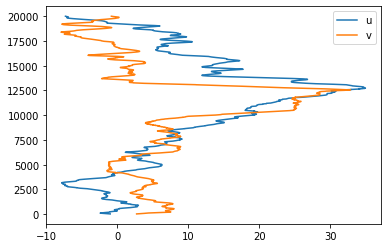

2016-05-30 00:00:00 10.701810253617854 32.61973340852796
2016-05-30 00:00:00 21.30108553189258 42.432577541114284
2016-08-19 00:00:00


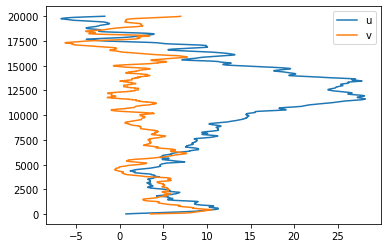

2016-08-19 00:00:00 10.460519372866871 13.945376588293378
2016-08-19 00:00:00 16.279011274296593 19.74966688923134


In [623]:
Process_sounding_data(dates[metric > 7000])

In [380]:
dbs = pickle.load(open('workspace/LASSOsoundings.pck','rb'))

In [386]:
np.degrees(dbs['theta'])

array([ 63.9220321 ,  39.44888917,  48.25723729,   8.75726517,
        69.48933263, -37.84661685,  25.81060496,  65.56051266,
        57.73751809,  43.86790714,  66.2336309 ,  56.63235443,
        30.15301136,  57.38859466,  14.2043329 ,  -8.67222321,
       -16.44418333, -11.75379165,   0.58703841,   2.04583697,
         5.19945537,  13.33210649,  53.88862347,  48.44996006,
        61.5042914 ,   8.80548087,   7.07803624,  32.47104313,
         6.96374824,   5.85774419,  58.22242269,  31.49578509,
        30.87528935,  18.43047276,  63.37455738, -49.1864483 ,
        28.52920974,  33.22491191, -21.93591644,   9.92919527,
        23.74775243,  65.45023546,  10.85441498])

In [842]:
import netCDF4 as nc
date = '20170627'
file = '/stor/soteria/hydro/shared/lasso_for_nate/doz_uvtrim_00/uvtrim_%s.nc' % date
fp = nc.Dataset(file)
file = '/stor/soteria/hydro/shared/lasso_for_nate/doz_uvtrim_01/uvtrim_%s.nc' % date
fp2 = nc.Dataset(file)

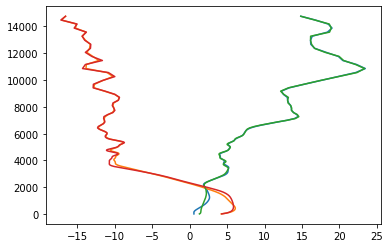

[   15.95399    47.82871    79.60036   111.24194   142.78258   174.24564
   205.6628    237.0419    268.3775    299.68915   330.97324   362.23175
   393.46686   424.674     455.85596   487.01385   518.15546   549.28467
   580.4004    611.5001    642.58527   673.65985   704.72375   735.7765
   766.8119    797.82544   828.8215    859.80334   890.77313   921.7368
   952.69745   983.6543   1014.60516  1045.5477   1076.4816   1107.404
  1138.3136   1169.2063   1200.0842   1230.9536   1261.8063   1292.64
  1323.4596   1354.2648   1385.0554   1415.8346   1446.6079   1477.3771
  1508.141    1538.8967   1569.643    1600.3779   1631.1014   1661.8108
  1692.5105   1723.2076   1753.9017   1784.592    1815.2728   1845.9418
  1876.6038   1907.2529   1937.8875   1968.5121   1999.1306   2029.7506
  2060.3691   2090.9856   2121.604    2152.227    2182.854    2213.4844
  2244.1174   2274.7505   2305.3853   2336.022    2366.6606   2397.2942
  2427.9058   2458.446    2488.9146   2519.3635   2549.811    25

In [845]:
it = 50
z = fp['z'][it,:]
u = fp['u'][it,:]
v = fp['v'][it,:]
plt.plot(u,z)
plt.plot(v,z)
z = fp2['z'][it,:]
u = fp2['u'][it,:]
v = fp2['v'][it,:]
plt.plot(u,z)
plt.plot(v,z)
plt.show()
print(z)